<a href="https://colab.research.google.com/github/jppego/fced_msp_g01/blob/main/20220121_fecd_msp_g01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Data Science and Engineering      <br>         Signal Processing Module      <br>  MASTER IN DATA SCIENCE AND ENGINEERING <br><br> Group #01 <br>
#ECG signal waveform and FFT feature extraction for diagnostic prediction
<small> João Pedro Pêgo, Pedro Gouveia, Ricardo Vilaça <br>
up199502401, up202100813, up201308080 <br><br> Faculdade de Engenharia, Universidade do Porto <br>FEUP Jan. 2022 </small>

###Install and import packages

In [45]:
#01 Install packages 
!pip install wfdb
!pip install matplotlib==3.1.1  ## it seems as there is some iconpatibility with some versions of this library

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [46]:
#02 import libraries
import wfdb
import pandas as pd
import numpy as np
import ast

import os
import requests

import matplotlib.pyplot as plt # by convention, we import pyplot as plt
import scipy as sp
# Added from Prof file update -- #
import scipy.fftpack
#------------------------------- #
import scipy.fft
import scipy.signal as sg
%matplotlib inline 

# Define main parameters of analysis

In [47]:
#03 paths to files in github
#path = 'path/to/ptbxl/'
path='https://raw.githubusercontent.com/jppego/fced_msp_g01/main/'


# sampling rate of the signal
sampling_rate=500

# number of records to use
# note if you choose nrec <300 or nrec > 2500 you might run into problems at the prediction phase. Due to limited amount of time to complete the project, we have decided to keep nrec = 2200 which is about 10% of the total dataset
nrec = 2200

# Record to plot as an example 
patient =  1

# signal used for feature extraction [1,..., 12]
rec_lead = 1

# range of frequencies (Hz) in the peridogram to extract the slope
rfmin = 10 
rfmax = 30

# number of plots to present (1-12)
# if nplots == 1 it will only plot the signal corresponding to rec_lead, otherwise plots the first nplots plots
nplots = 2



# PTB-XL, a large publicly available electrocardiography dataset
<small> 
Patrick Wagner ,  Nils Strodthoff ,  Ralf-Dieter Bousseljot ,  Wojciech Samek ,  Tobias Schaeffter 

<br>
</small> 

DOI: https://doi.org/10.13026/x4td-x982 

Source: https://physionet.org/content/ptb-xl/1.0.1/

The dataset comprises **21837 clinical 12-lead ECG records of 10 seconds length from 18885 patients**, where 52% are male and 48% are female with ages covering the whole range from 0 to 95 years (median 62 and interquantile range of 22). The value of the dataset results from the comprehensive collection of many different co-occurring pathologies, but also from a large proportion of healthy control samples. The distribution of diagnosis is as follows, where we restrict for simplicity to diagnostic statements aggregated into superclasses (note: sum of statements exceeds the number of records because of potentially multiple labels per record):


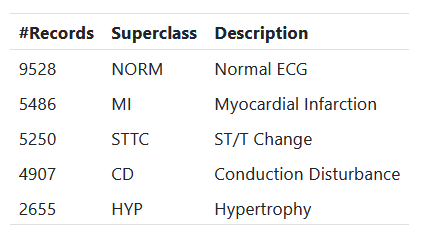



The waveform files are stored in WaveForm DataBase (WFDB) format with 16 bit precision at a resolution of 1μV/LSB and a sampling frequency of 500Hz (records500/). For the user’s convenience we also release a downsampled versions of the waveform data at a sampling frequency of 100Hz (records100/).

#Functions

In [48]:
#Reads the WFDB file. There is a bug in the wfdb library which does not allow the import directly from github so this function downloads the file and reads it locally
def get_file(sampling_rate, static_path, path):
    """
    Workaround to make rdsamp read a non-local file (http request)
    Gets both the "static_path" + "path" + either .dat/.hea files to local, 
        saves them, and only then runs wfdb.rdsamp on the result.
    Returns the result of rdsamp
    """ 
    
    filename = path.split('/')[-1]

    with open(filename + '.dat', 'wb') as f:
        r = requests.get(static_path + path + '.dat')
        f.write(r.content)

    with open(filename + '.hea', 'wb') as f:
        r = requests.get(static_path + path + '.hea')
        f.write(r.content)

    result = wfdb.rdsamp(filename)

    os.remove(filename+'.dat')
    os.remove(filename+'.hea')

    return result

# Signal to extract features
def patient_signal(recordP,n):
  _sig = recordP[:, n]
  return _sig

# creates an array with the time steps
# the time step is the inverse of the sampling rate (100Hz or 500 Hz)
def sampling(samplingrate,lenSignal):
  t_step = 1./sampling_rate
  t = np.array([i * t_step for i in range(lenSignal)]) 
  return t
  


In [49]:
# Reads the metadata from each patient (ecg_id, age, sex, weight, diagnostic, etc.)
import pandas
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

Y = Y.head(nrec) # limits the df to the first nrec records
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Appending signal data for each patient on a new column
if sampling_rate == 100:
    Y['signal_data'] = Y['filename_lr'].apply(lambda filename: get_file(sampling_rate, path, filename)[0])
else:
    Y['signal_data'] = Y['filename_hr'].apply(lambda filename: get_file(sampling_rate, path, filename)[0])

ecg_data = Y.filter(["ecg_id","age","sex","weight","scp_codes"])
#ecg_data

In [50]:
#07
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


In [51]:
# Returns the superclass with the higher likelihood
def get_higher_superclass(d):
    diagnostic = sorted(((key, value) for key, value in d.items()), key=lambda d: d[1], reverse=True)[0][0]

    try:
      return agg_df[agg_df.index == diagnostic]['diagnostic_class'].iloc[0]
    except IndexError:
      return None

Y['diag_superclass'] = Y['scp_codes'].apply(get_higher_superclass)

In [52]:
# if the superclass is not set, drops the record
Y = Y[pd.isna(Y['diag_superclass']) == False]

In [53]:
#08
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


# Signal selection

"**Parts of an ECG**

The standard ECG has 12 leads. Six of the leads are considered “limb leads” because they are placed on the arms and/or legs of the individual. The other six leads are considered “precordial leads” because they are placed on the torso (precordium).

The six limb leads are called lead I, II, III, aVL, aVR and aVF. The letter “a” stands for “augmented,” as these leads are calculated as a combination of leads I, II and III.

The six precordial leads are called leads V1, V2, V3, V4, V5 and V6.
"

<small>
<a href="https://www.healio.com/cardiology/learn-the-heart/ecg-review/ecg-interpretation-tutorial/introduction-to-the-ecg">Source</a></small>


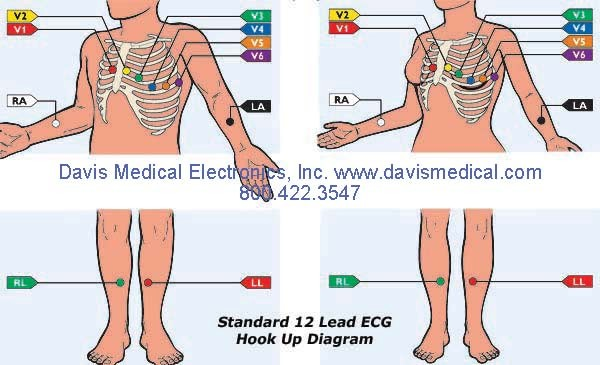

In [54]:
#11
def patient_record(n):
  XYZ =  Y['signal_data'][n]
  return  XYZ

ECG_sigs = patient_record(patient)
ECG_sigs.shape

(5000, 12)

In [55]:
# Signal to extract features
sig = ECG_sigs[:, rec_lead]


# Plots the ECG



![title](https://m3.healio.com/~/media/924e8d3e4e2855d2e892602e7878c3a5.jpg)


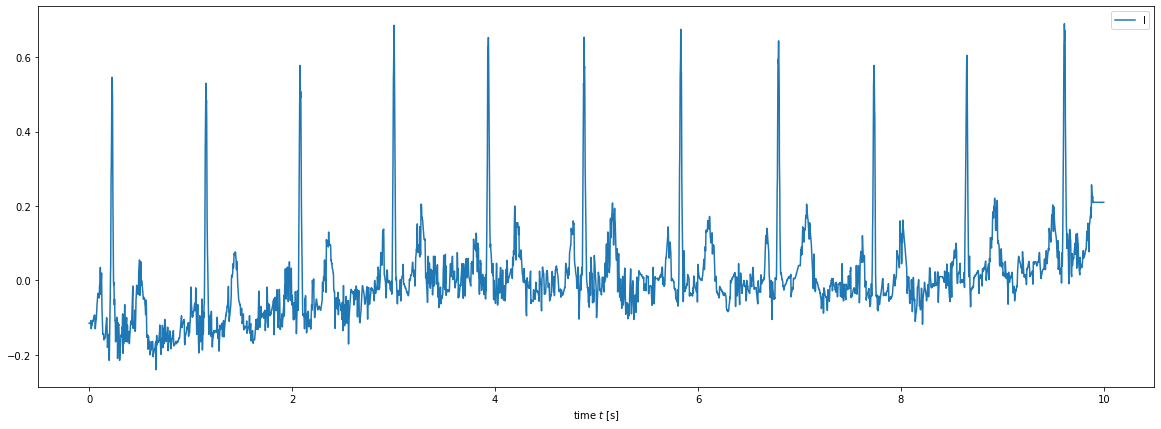

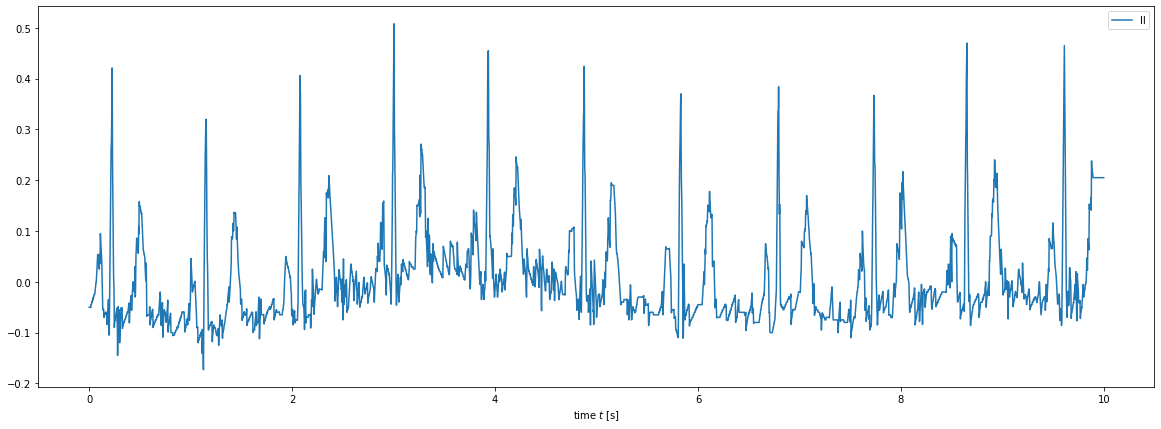

In [56]:
# creates an array with the time steps
# the time step is the inverse of the sampling rate (100Hz or 500 Hz)
lenSignal = len(sig)
t = sampling(sampling_rate,lenSignal)

#https://www.healio.com/cardiology/learn-the-heart/ecg-review/ecg-interpretation-tutorial/introduction-to-the-ecg
#Labels for each ECG lead
signal_lbl =['I', 'II', 'III', 'aVL', 'aVR', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 

# settings for the size of the images
plt.rcParams['figure.figsize'] = [20, 7]  # Bigger images   

if nplots == 1:
    plt.figure()
    plt.plot(t, sig, label=signal_lbl[rec_lead])
    plt.xlabel('time $t$ [s]')
    plt.legend()

else:
  for i in range(nplots):
    sig = ECG_sigs[:, i]
    plt.figure()
    plt.plot(t, sig, label=signal_lbl[i])
    plt.xlabel('time $t$ [s]')
    plt.legend()



In the above example, it can be seen that some signals have long wavelength components. This is an indicator that the patient was moving (in an ambulance or was not completly at rest). The long wavelength is associated with very low frequencies, below the expected frequency for a healthy heart rate of about 1 Hz.

# FFT - Frequency domain

In the frequency domain we will plot the FFT and the periodogram. For the FFT, only the positive frequencies will be shown and used, since this is a symmetric graph. 
The FFT will have has many points as the original signal (10 s * sampling rate). In this case, we are using 500 Hz, so we will have an FFT with 5000 points, which streches from -250Hz till 250 Hz. We will only show the range 0-50 Hz because for higher frequencies it is mainly noise.

We also compute the average power of the FFT, its median and standard deviation. 

An observation of the periodogram reveals that there is a trend in the range 10-30 Hz, so a linear regression will be plotted.

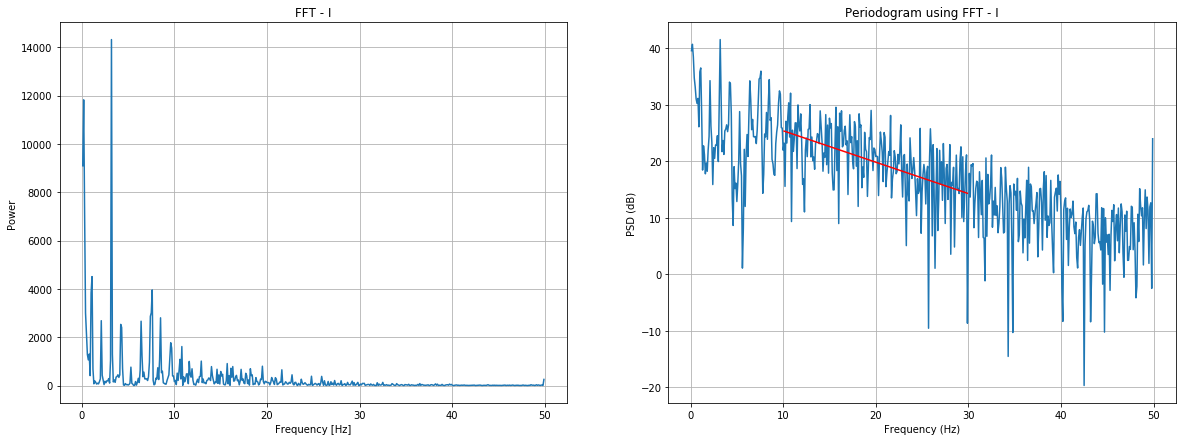

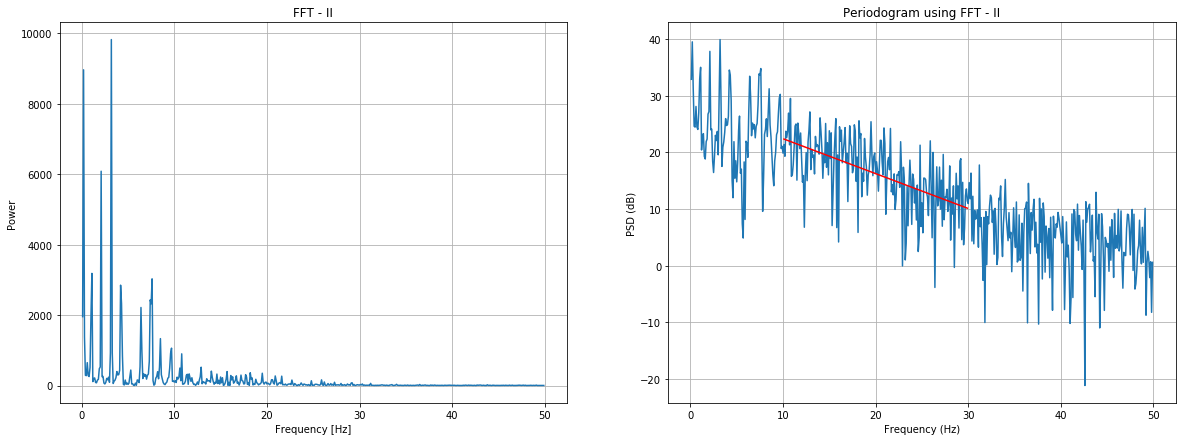

In [57]:
import matplotlib.pyplot as plt

# function to extract features from the FFT
def peak_freq (t, sig, lead, fs, rfmin, rfmax):
  from scipy import stats
  from scipy.signal import find_peaks

# The FFT of the signal
  signal_fft = sp.fft.fft(sig)
  signal_fft

# Power spectral density (PSD) estimate
  power = np.abs(signal_fft)**2
  
# the time step is the inverse of the sampling rate
  t_step = 1./sampling_rate

# The corresponding frequencies
  sample_freq = sp.fft.fftfreq(len(sig), d=t_step)

# Find the peak frequencies: we can focus on only the positive frequencies
  pos_mask = np.where(sample_freq > 0)
  freqs = sample_freq[pos_mask]
  powers = power[pos_mask]
    
# power statistics
  power_avg = np.average(powers)         # average
  power_median = np.median(powers)       # median
  power_stdev = np.std(powers)           # standard deviation
  
  # finds the peaks in the FFT which are equalled or exceded 5% of time
  peaks, _ = find_peaks(powers, height = power_avg + stats.norm.ppf(.95) * power_stdev)
  pk_freq = freqs[peaks] # frequencies corresponding to the peaks

## Periodogram analysis
# Limit the linear regression to the rfmin-rfmax Hz interval
  i = (sample_freq > rfmin ) & (sample_freq < rfmax)
    
  x = sample_freq[i]
  y = 10 * np.log10(power[i])
  res = stats.linregress(x, y)

  return freqs, powers, pk_freq, power_avg, power_median, power_stdev, res.slope


# function to plot the FFT
def  plot_FFT (t, sig, lead, sampling_rate, rfmin, rfmax):
  from scipy import stats
  freqs, powers, pk_freq, power_avg, power_median, power_stdev, slope = peak_freq (t, sig, lead, sampling_rate, rfmin, rfmax)

  
  #To only obtain the positive frequencies and limit to the 50 Hz. Past this, it's mainly rubish
  i = (freqs < 50)
      

  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
  # FFT plot
  ax1.plot(freqs[i], powers[i],  label=lead)
  ax1.set_xlabel('Frequency [Hz]')
  ax1.set_ylabel('Power')
  ax1.set_title("FFT - " + lead)
  ax1.grid()

  # PSD plot
  ax2.plot(freqs[i], 10 * np.log10(powers[i]), label=lead)

  # Linear regression of the periodogram
  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

  # Limit the linear regression to the rfmin-rfmax Hz interval
  i = (freqs > rfmin ) & (freqs < rfmax)
  
  x = freqs[i]
  y = 10 * np.log10(powers[i])
  res = stats.linregress(x, y)
  ax2.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

  
  # set lables, title and plot
  ax2.set_xlabel('Frequency (Hz)')
  ax2.set_ylabel('PSD (dB)')
  ax2.set_title( "Periodogram using FFT - " + lead )
  ax2.grid()
  plt.plot(label=lead)

  plt.show()

  return


if nplots == 1:
  plot_FFT (t, sig, rec_lead, sampling_rate, rfmin, rfmax)
else:
  for l in range(nplots):
    sig = ECG_sigs[:, l]

    lead=signal_lbl[l]
    plot_FFT (t, sig, lead, sampling_rate, rfmin, rfmax)


# Signal filtering

We have seen that we have undesired low frequencies (the patient is in motion) and very high frequencies (signal noise). We will use a filter to clean the signal and then proceed with the feature extraction.

In [58]:
# Parameters for the filter


# # initialize variables
N = 6 # order of the filter to be used. Above this value there seems to be some artifacts in the filter
lowcut = 0.4       # lowest frequency of the filter
highcut = 50       # highest frequency of the filter
fs = sampling_rate


###Building a band pass filter

A band pass filter will filter all frequencies except the ones between its lower and higher bound, here defined by lowcut and highcut. We now represent the filter for several order values and conclude that for very high orders some artifacts occur in the filter (values higher than 1), which cannot be accepted. The probable explanation resides in the fact that the lower bound (0.4Hz) is too close to 0 and the filter has difficulty to correctly approximate a top-hat filter. Therefore, we decided to go for a lower order of the filter.

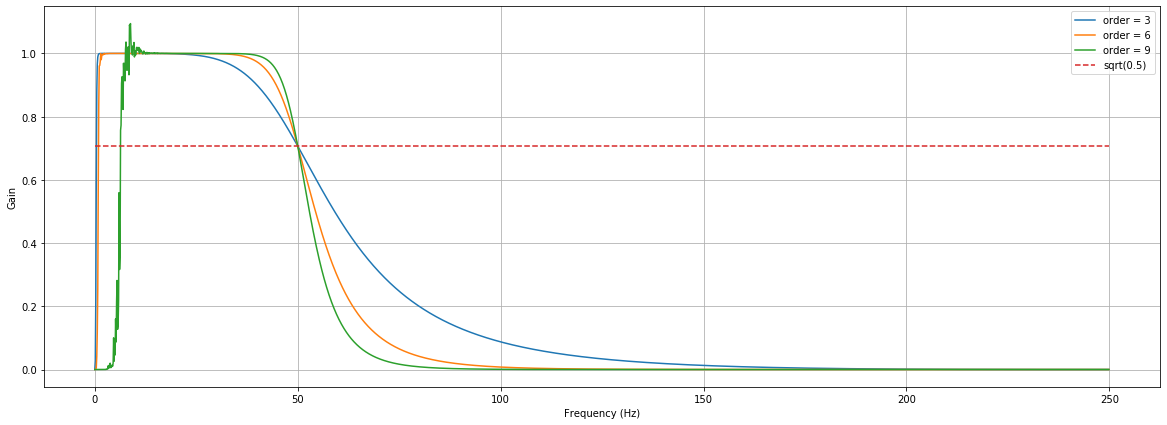

In [59]:
# https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
from scipy.signal import butter, lfilter
import sys


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    # -------------------------------
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz
    # -------------------------------

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]: 
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2048)

        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)


    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')


### Filter the signal

Here we demonstrate the effect of the filter on the signal, which loses the low frequency waves and becomes less noisy. 

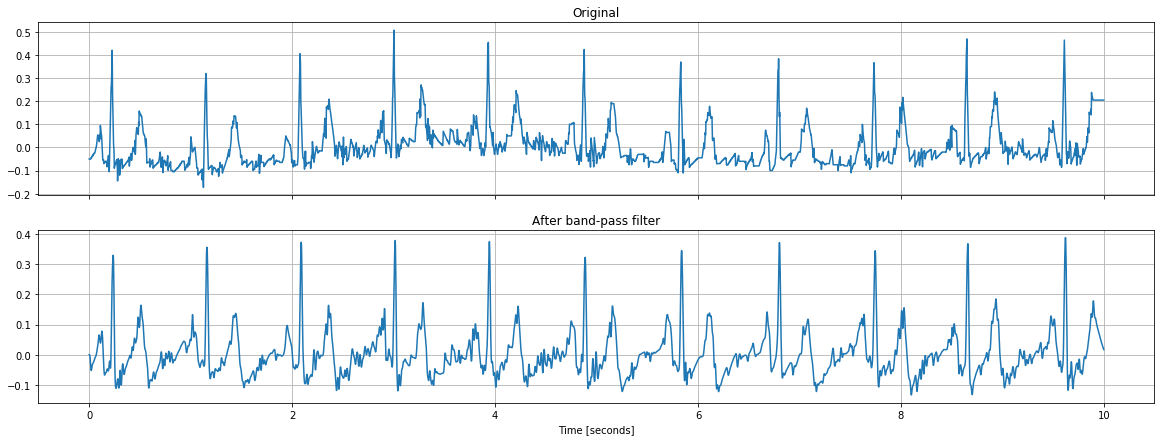

In [60]:
#Demonstration of the effect of the filter on the ECG signal  
import matplotlib.pyplot as plt

def filter_signal (sig, N, lowcut, highcut, fs):
  from scipy import signal


  sos = signal.butter(N, [lowcut, highcut], 'bandpass', fs=sampling_rate, output='sos')
  filtered = signal.sosfilt(sos, sig)

  return filtered

#original signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('Original')
ax1.grid()

#filtered signal
filtered = filter_signal (sig, N, lowcut, highcut, sampling_rate)

ax2.plot(t, filtered)
ax2.set_title('After band-pass filter')
ax2.set_xlabel('Time [seconds]')
plt.grid()

plt.show()

# FFT feature extraction


Once the signal is filtered, the feature extraction can occur. From the FFT we will extract the frequencies of the peak values in the ECG signal (those higher than power_avg + 1.65 * power_stdev), the number of peaks, the average and standard deviation of the power and the slope of the linear regression in the periodogram.

In [61]:
#applies the previous built functions to extract features and plots them to the display
if nplots == 1:
  filtered = filter_signal (sig, N, lowcut, highcut, sampling_rate)
  freqs, powers, pk_freq, power_avg, power_median, power_stdev, slope = peak_freq (t, filtered, rec_lead, sampling_rate, rfmin, rfmax)
  print(f'The peak frequencies of lead {lead} is \n {pk_freq}')
  print(f'Number of peaks of lead {lead} is \n {len(pk_freq)}')
  print(f'Average power: {round(power_avg,3)} ; Power std dev: {round(power_stdev,3)} \n')
  print(f"slope of periodogram in interval [{rfmin}-{rfmax}]Hz: {slope:.6f} \n")

else: 
  # loops through all the channels
  for l in range(nplots):
      sig = ECG_sigs[:, l]    
      lead=signal_lbl[l]
      filtered = filter_signal (sig, N, lowcut, highcut, sampling_rate)
      freqs, power, pk_freq, power_avg, power_median, power_stdev, slope = peak_freq (t, filtered, lead, sampling_rate, rfmin, rfmax)
      print(f'The peak frequencies of lead {lead} is \n {pk_freq}')
      print(f'Number of peaks of lead {lead} is \n {len(pk_freq)}')
      print(f'Average power: {round(power_avg,3)} ; Power std dev: {round(power_stdev,3)} \n')
      print(f"slope of periodogram in interval [{rfmin}-{rfmax}]Hz: {slope:.6f} \n")
    


The peak frequencies of lead I is 
 [ 1.1  2.1  3.2  4.3  5.3  6.4  7.4  7.6  8.2  8.5  8.7  9.6 10.6 10.8
 11.6 12.9 14.  14.6 15.7 16.1 16.3 18.2 19.5]
Number of peaks of lead I is 
 23
Average power: 45.333 ; Power std dev: 358.553 

slope of periodogram in interval [10-30]Hz: -0.542839 

The peak frequencies of lead II is 
 [ 1.1  2.1  3.2  4.3  5.3  6.4  7.4  7.6  8.5  9.7 10.8]
Number of peaks of lead II is 
 11
Average power: 29.579 ; Power std dev: 274.07 

slope of periodogram in interval [10-30]Hz: -0.627933 



# Waveform analysis and feature extraction


![title](https://www.frca.co.uk/images_main/resources/ECG/ECG-resource1.gif)

<small>
<a href="https://www.frca.co.uk/images_main/resources/ECG/ECG-resource1.gif">Picture source</a></small>



There are many ways to extract features and information from the ECG waveform, which is the most common form of analysis. An excellent package for ECG analysis is <a href="https://neurokit2.readthedocs.io/en/latest/ ">Neurokit</a>

Here, we will only focus on the R peaks, which occur for each heart beat. The RR interval corresponds to the period of the heart beat and its inverse corresponds to the heart rate. Heart rate variability is a very relevant topic and we will address it by looking at the coefficient of variation of the heart rate. For heart rate variability, a long duration ECG (10 min) is required. Since we only have records we a length of 10 seconds, the conclusions are limited.  


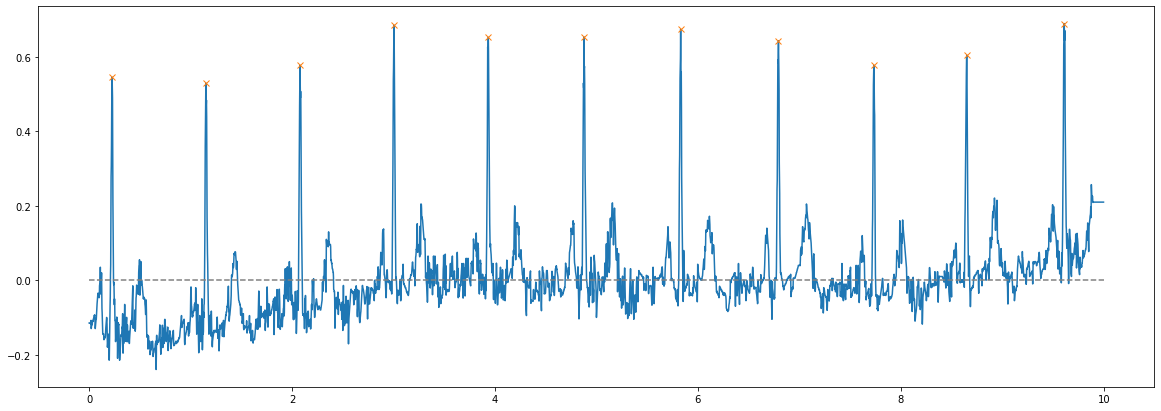

Average HR 63.956 bpm; HR Coef of variation 0.0164
-----------------------------------------------


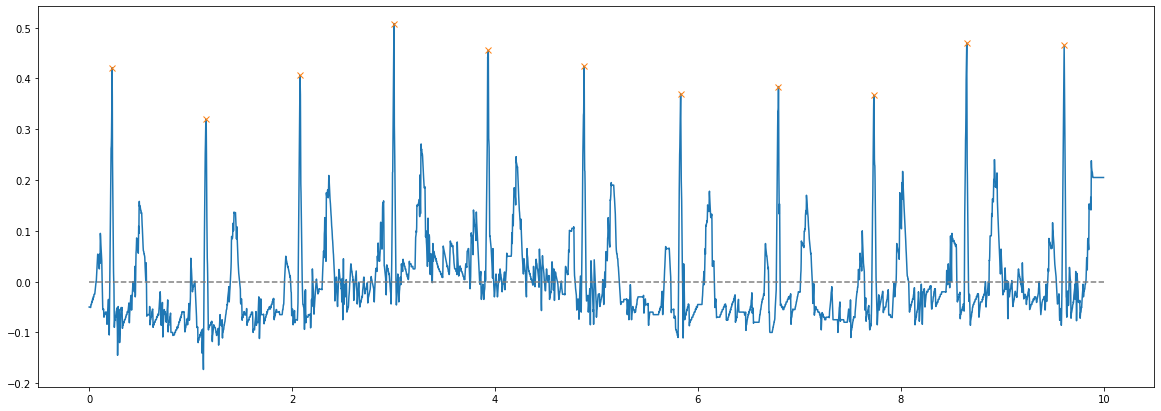

Average HR 63.956 bpm; HR Coef of variation 0.0164
-----------------------------------------------


In [62]:
# Heart rate features extraction
def HRstats (sig, sampling_rate):
  import matplotlib.pyplot as plt
  from scipy.misc import electrocardiogram

  from scipy.signal import find_peaks

  peaks, _ = find_peaks(sig, height= 0.6*sig.max(), width = 0.01*sampling_rate)

  ### Compute the average interval between peeks
  frequencies = sampling_rate / np.diff(peaks) # sampling rate in Hz divided by the number of samples between peaks 

  avg_HR = np.average(frequencies)
  std_HR = np.std(frequencies)

  return peaks, avg_HR, std_HR

sig = ECG_sigs[336]
sig = sig[1]

if nplots == 1:
  peaks, avg_HR, std_HR = HRstats (sig, sampling_rate)

  plt.plot(t, sig)
  plt.plot(t[peaks], sig[peaks], "x")
  plt.plot(np.zeros_like(sig[peaks]), "--", color="gray")
  plt.show()

  print(f'Average HR {round(avg_HR * 60,3)} bpm; HR Coef of variation {round(std_HR/avg_HR,4)}')
  print('-----------------------------------------------')

else: 
  # loops through all the channels
  for l in range(nplots):
      signal = ECG_sigs[:, l]    
      lead=signal_lbl[l]
      peaks, avg_HR, std_HR = HRstats (signal, sampling_rate)

      plt.plot(t, signal)
      plt.plot(t[peaks], signal[peaks], "x")
      plt.plot(np.zeros_like(signal[peaks]), "--", color="gray")
      plt.show()
      
      print(f'Average HR {round(avg_HR * 60,3)} bpm; HR Coef of variation {round(std_HR/avg_HR,4)}')
      print('-----------------------------------------------')

##Feature extraction for the complete dataset (nrec records)

In [63]:
# function to filter the signal and feature extraction
def feature_creation(patient):
  # Get patient records
  pat_rec = patient['signal_data']

  # 
  pat_sig = list(patient['signal_data'][n][0] for n in range(len(patient['signal_data'])))

  # Length do signal
  len_sig = len(patient['signal_data'])

  # Get sampling
  _t = sampling(sampling_rate,len_sig)

  # Get signal name
  _lead = signal_lbl[rec_lead]

  # Get signal filtered
  # 
  filtered_sig = filter_signal(pat_sig, N, lowcut, highcut, sampling_rate)

  # Get features

  # f1 - peak frequencies of lead with a power of percentile 95%
  # f2 - nr of peak frequencies of lead
  # f3 - average power
  # f4 - median power
  # f5 - standard deviation power
  # f6 - slope of periodogram in interval 

  # FFT feature extraction
  freqs, power, f1__peak_freq, f3__power_avg, f4__power_median, f5__power_stdev, f6__slope = peak_freq (_t, filtered_sig, _lead, sampling_rate, rfmin, rfmax)

  # waveform feature extraction
  peaks, avg_HR, std_HR = HRstats (filtered_sig, sampling_rate)

  # Get the 4 first peaks (Y['npeaks'].min() = 4)
  peaks = tuple(f1__peak_freq[n] for n in range(4))

  return (len(f1__peak_freq), f3__power_avg, f4__power_median, f5__power_stdev, f6__slope, avg_HR, std_HR / avg_HR) + peaks

In [64]:
Y[['npeaks', 'power_avg', 'power_median', 'power_stdev', 'slope', 'avg_HR', 'cv_HR',
    'peak1', 'peak2', 'peak3', 'peak4']] = Y.apply(feature_creation, axis=1).apply(pd.Series)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Preparing data for clustering / predicition

We start by using k-means to identify clusters in the datatset. Then we add the cluster as an additional feature to the data set. Finally, we separate the dataset in training/testing groups to evaluate the prediction algorithm

In [65]:
from sklearn.preprocessing import LabelEncoder

In [66]:
target = 'diag_superclass'
features = ['sex', 'age', 'weight', 'npeaks', 'power_avg', 'power_median',
            'power_stdev', 'slope', 'avg_HR', 'cv_HR', 'peak1', 'peak2', 'peak3', 'peak4']
columns_to_keep = features + [target]

In [67]:
# Keep only the columns we want for the clustering prediction
df = Y[columns_to_keep]

In [68]:
# Exploring diagnostic superclass
Y['diag_superclass'].value_counts()

NORM    1130
STTC     351
CD       305
MI       258
HYP      119
Name: diag_superclass, dtype: int64

The original dataset is much larger, but the superclasses is sub-dataset is representative of the original one:

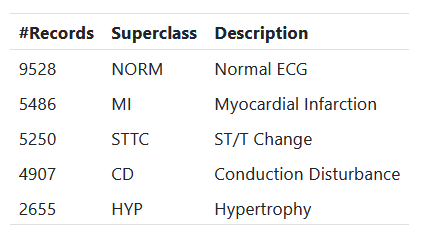

In [69]:
# Check for null values
df.isna().any()

sex                False
age                 True
weight              True
npeaks             False
power_avg          False
power_median       False
power_stdev        False
slope              False
avg_HR              True
cv_HR               True
peak1              False
peak2              False
peak3              False
peak4              False
diag_superclass    False
dtype: bool

In [70]:
# Handle null values
df = df.dropna(subset=['avg_HR', 'cv_HR', 'age', 'weight'], axis=0, how='any')

In [71]:
# Encoding categorical variables
df[target] = LabelEncoder().fit_transform(df[target])

## Clustering

In [72]:
from sklearn.cluster import KMeans

In [73]:
# Creating a different dataframe with normalized values to do the clustering
cluster_df = df.copy()

for column in df.columns:
  cluster_df[column] = (cluster_df[column] - cluster_df[column].mean()) / cluster_df[column].std()

In [74]:
cluster_df.head()

,sex,age,weight,npeaks,power_avg,power_median,power_stdev,slope,avg_HR,cv_HR,peak1,peak2,peak3,peak4,diag_superclass
ecg_id,,,,,,,,,,,,,,,
1,0.895799,0.006300,-0.507568,-0.359645,-0.597688,-0.130486,-0.418979,-0.010677,-0.246682,-0.326905,0.248232,0.225455,0.320865,0.411449,0.343014
2,-1.115677,-1.903842,-0.050628,-1.361225,-0.295170,-0.135065,-0.007481,0.887199,-0.469946,-0.135502,-0.425893,-0.355832,-0.525216,-0.803804,0.343014
3,0.895799,-0.974584,-0.115906,-0.205556,-0.316358,0.096879,-0.270576,0.334401,-0.251458,-0.306950,0.248232,0.225455,0.320865,0.276421,0.343014
4,-1.115677,-1.645715,0.732697,0.641934,-0.139542,-0.127666,-0.194080,-1.553042,-0.093577,-0.169691,0.472940,0.690484,0.405473,-0.128663,0.343014
5,0.895799,-1.903842,-0.050628,0.564890,-0.733207,-0.127818,-0.526692,0.471962,-0.212590,-0.162422,0.248232,-0.704604,-0.525216,-0.871318,0.343014


In [75]:
df.head()

,sex,age,weight,npeaks,power_avg,power_median,power_stdev,slope,avg_HR,cv_HR,peak1,peak2,peak3,peak4,diag_superclass
ecg_id,,,,,,,,,,,,,,,
1,1,56.0,63.0,23.0,45.332668,5.038841e-05,358.553237,-0.542839,1.065734,0.017222,1.1,2.1,3.2,4.3,3
2,0,19.0,70.0,10.0,74.535669,6.891897e-07,859.976260,-0.339540,0.789373,0.059900,0.8,1.6,2.2,2.5,3
3,1,37.0,69.0,25.0,72.490288,2.518219e-03,539.387537,-0.464706,1.059822,0.021671,1.1,2.1,3.2,4.1,3
4,0,24.0,82.0,36.0,89.558938,8.099846e-05,632.600247,-0.892065,1.255251,0.052276,1.2,2.5,3.3,3.5,3
5,1,19.0,70.0,35.0,32.250565,7.934642e-05,227.302184,-0.433559,1.107933,0.053897,1.1,1.3,2.2,2.4,3


In [76]:
# Creating n clusters
km = KMeans(n_clusters=3)
cluster_df['cluster'] = km.fit_predict(cluster_df[features])

In [77]:
# Cluster value back to the original df
df = df.merge(cluster_df['cluster'], how='left', left_index=True, right_index=True)

In [78]:
# Getting the centroids of each cluster
centroids = km.cluster_centers_
labels = km.labels_

cluster 2
In this cluster we have 837 signals


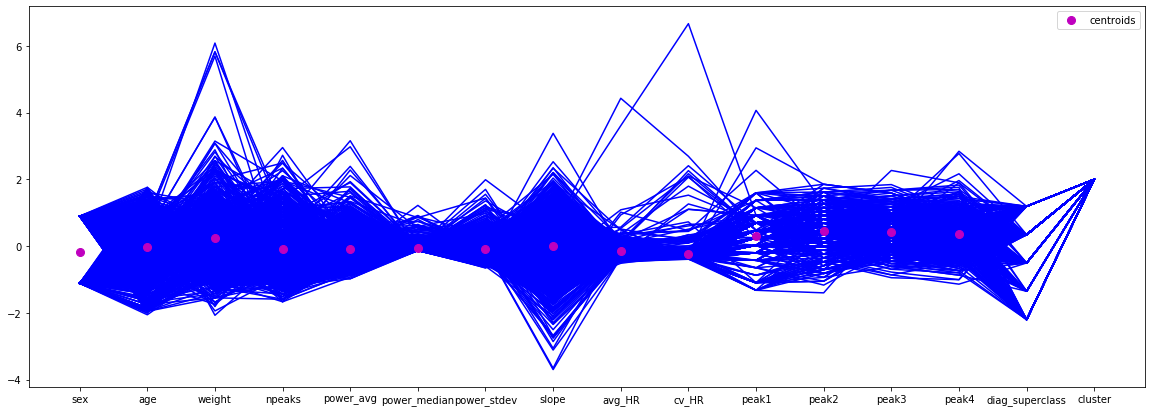

cluster 1
In this cluster we have 677 signals


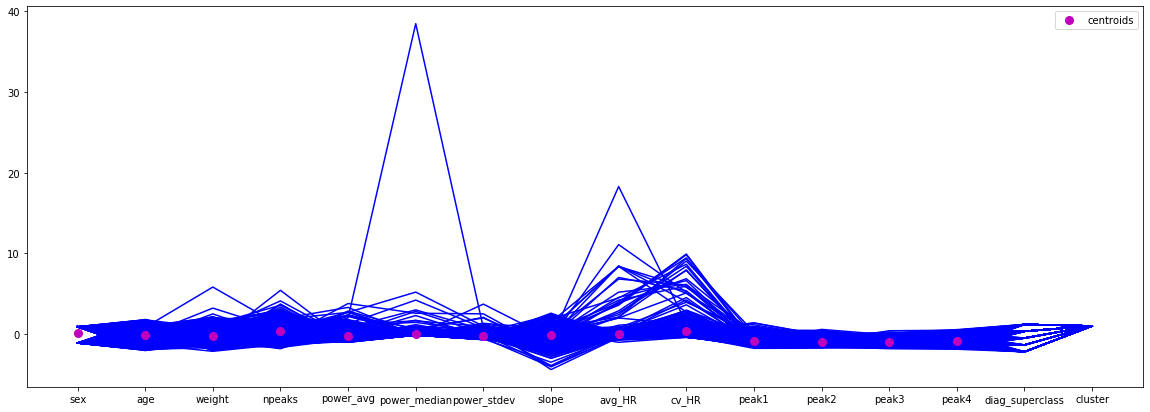

cluster 0
In this cluster we have 215 signals


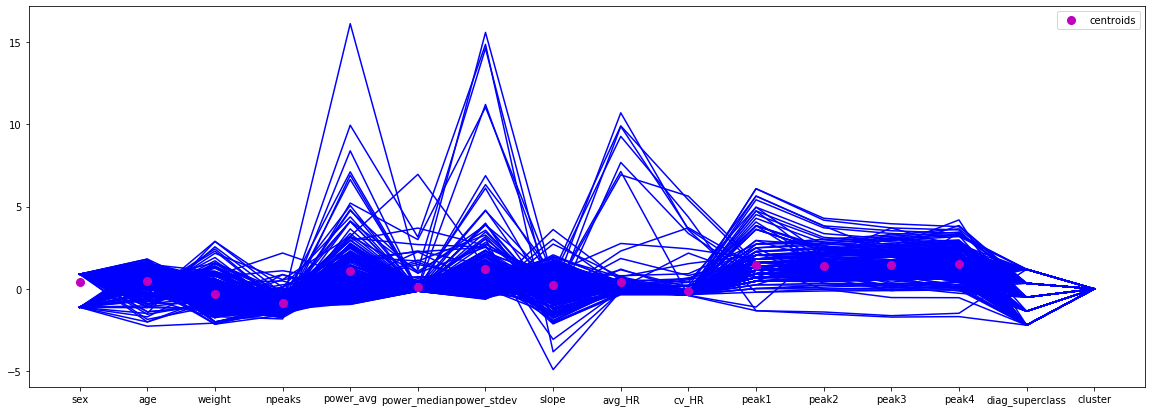

In [79]:
# Plotting each cluster
for cluster in list(cluster_df['cluster'].unique()):
    n_i = len(cluster_df[cluster_df['cluster'] == cluster])  # number of elements in cluster i

    print("cluster "+str(cluster))
    print("In this cluster we have " + str(n_i)+" signals")

    for k in range(0, n_i):
        plt.plot(cluster_df[cluster_df['cluster'] == cluster].iloc[k], 'b')

    plt.plot(centroids[cluster], 'mo', markersize=8, label='centroids')
    plt.legend(loc='best')
    plt.show()


## Prediction

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score
from lightgbm import Dataset, train
import seaborn as sns

In [81]:
# Add cluster to our features
features += ['cluster']

In [82]:
# Splits the features from the target column
x = df.loc[:, features]
y = np.array(df.loc[:, target])

In [83]:
# Splits the dataset into train and test (25% for test by default)
x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [84]:
# Create LGBM datasets
train_data = Dataset(x_train, label=y_train)
valid_data = Dataset(x_valid, label=y_valid)

In [85]:
# Setting parameters for the model
parameters = {
    'objective': 'multiclass',
    'num_classes': len(df[target].unique()),
    'boosting': 'gbdt',
}


In [86]:
model = train(
    params=parameters,
    train_set=train_data,
    valid_sets=valid_data,
    categorical_feature=['cluster']
)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cluster']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's multi_logloss: 1.23942
[2]	valid_0's multi_logloss: 1.21569
[3]	valid_0's multi_logloss: 1.19452
[4]	valid_0's multi_logloss: 1.17914
[5]	valid_0's multi_logloss: 1.16891
[6]	valid_0's multi_logloss: 1.15813
[7]	valid_0's multi_logloss: 1.14965
[8]	valid_0's multi_logloss: 1.14317
[9]	valid_0's multi_logloss: 1.13627
[10]	valid_0's multi_logloss: 1.13234
[11]	valid_0's multi_logloss: 1.12776
[12]	valid_0's multi_logloss: 1.12462
[13]	valid_0's multi_logloss: 1.12018
[14]	valid_0's multi_logloss: 1.11853
[15]	valid_0's multi_logloss: 1.11691
[16]	valid_0's multi_logloss: 1.11583
[17]	valid_0's multi_logloss: 1.11455
[18]	valid_0's multi_logloss: 1.11104
[19]	valid_0's multi_logloss: 1.10978
[20]	valid_0's multi_logloss: 1.10805
[21]	valid_0's multi_logloss: 1.10833
[22]	valid_0's multi_logloss: 1.10714
[23]	valid_0's multi_logloss: 1.10725
[24]	valid_0's multi_logloss: 1.10743
[25]	valid_0's multi_logloss: 1.10937
[26]	valid_0's multi_logloss: 1.11157
[27]	valid_0's multi_

In [87]:
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)

roc_auc_score(y_valid, y_valid_pred, multi_class='ovr', average="macro")
#precision_score(y_valid, y_valid_pred, average=None)
# recall

0.7374868753583171

Here we verify the relative importance of each feature for the predicting algorithm. It is clear that several of the extracted features (in time and frequency domain) are relevant for the prediction. On the other hand, the cluster is the least relevant feature, which means the population sample is rather homogeneous.

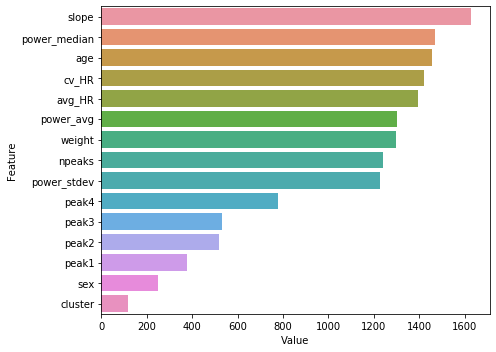

In [88]:
feature_imp= pd.DataFrame(sorted(zip(model.feature_importance(), x_train.columns), reverse = True), columns = ['Value', 'Feature'])
plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()

#Conclusions

It was clear from this ECG analysis that a diagnosis can be predicted based on some of the features extracted from the signal. A more refined analysis, that would look at the details of the waveform would surely bring more accuracy to the method. But since the purpose of the project was to learn how to extract features and not make the predictions, the group was satisfied with the results. We were very happy to realize some of the features we selected, in particular those that translate the variability of the signals (e.g, cv_HR, slope), are amongs those that most contribute to the predicting algorithm.
